In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
import matplotlib.dates as mdates

pd.options.display.max_columns = 250
pd.options.display.max_rows=150

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Point

from scipy.interpolate import interp1d

import datetime

from tqdm import tqdm
import networkx as nx

import sys
sys.path.insert(1, '../graph_construction/')
from HydroGraph_functions import *

In [2]:
# Read in the needed data

WILakes  = pd.read_pickle("../graph_construction/WILakes.df")
WIRivers = pd.read_pickle("../graph_construction/WIRivers.df")
agland   = pd.read_pickle("../graph_construction/agland.df")

HUC8  = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC8/HUC8.shp")
HUC10 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC10/HUC10.shp")
HUC12 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC12/HUC12.shp")

WItofroms_agg   = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_agg.csv")

WI    = gpd.GeoDataFrame.from_file("../graph_construction/lakes_rivers/WI/WI.shp")

In [3]:
# Build the aggregated garph
G_agg = build_graph(WItofroms_agg)

In [4]:
# Get the dictionary of positions, list of node colors, and list of node sizes for plotting
G_agg_pos, node_colors_agg, node_size_agg = get_pos_dict(G_agg, WILakes, WIRivers)

100%|██████████████████████████████████████████████████████████████████████████████| 8526/8526 [01:36<00:00, 88.78it/s]


In [5]:
# Define the set of all nodes in the graph
all_nodes = [i for i in G_agg.nodes]

In [6]:
# Create a GeoDataFrame containing the two source locations
# Source1 is at a latitude of 44.85 and longitude of -89.35
# Source2 is at a latitude of 44.85 and longitude of -89.295

df = pd.DataFrame( {"Node":["source1","source2"], "huc12":[70700030102,40302021001], 'latitude':[44.85,44.85], 'longitude':[-89.35,-89.295]})

sources = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
sources = sources.set_crs("EPSG:4326")

In [7]:
# Add the new sources to the graph; also add their positions to the dictionary of positions, G_agg_pos
G_source = add_source_to_graph(G_agg, WILakes, WIRivers, sources)
G_agg_pos["source1"] = np.array([sources.geometry.x.values[0], sources.geometry.y.values[0]])
G_agg_pos["source2"] = np.array([sources.geometry.x.values[1], sources.geometry.y.values[1]])

In [8]:
# Create a downstream graph for Source1 and Source2
G_down1,x = get_downstream_graph_and_cols(G_source, "source1", WILakes, WIRivers)
G_down2,x = get_downstream_graph_and_cols(G_source, "source2", WILakes, WIRivers)

# Get the list of node colors and node sizes for plotting
node_colors1, node_size1 = color_nodes(G_down1, WILakes, WIRivers, sources)
node_colors2, node_size2 = color_nodes(G_down2, WILakes, WIRivers, sources)

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 303.85it/s]


In [9]:
# Get the set of nodes in the downstream graphs
nodes1 = [i for i in G_down1.nodes]
nodes2 = [i for i in G_down2.nodes]

<AxesSubplot:>

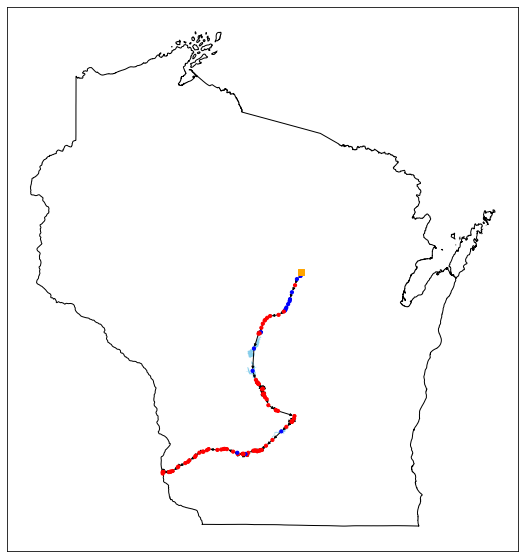

In [10]:
# Plot the downstream graph for Source1; plot the polygon of the lakes as well

fig, ax = plt.subplots(figsize=(10,10))

all_nodes = [i for i in G_down1.nodes]

WI.plot(ax=ax, color="none", edgecolor="black")
WILakes[WILakes.COMID.isin(all_nodes)].plot(ax=ax, color="skyblue")
nx.draw_networkx(G_down1,pos=G_agg_pos,node_size=(np.array(node_size1)),with_labels=False,arrowsize=5,ax=ax,node_color=node_colors1)#, node_shape=node_shape_c)#,markersize=markersize)
sources[sources.Node == "source1"].plot(ax=ax, color="orange", marker="s", markersize=30, zorder=100)


<AxesSubplot:>

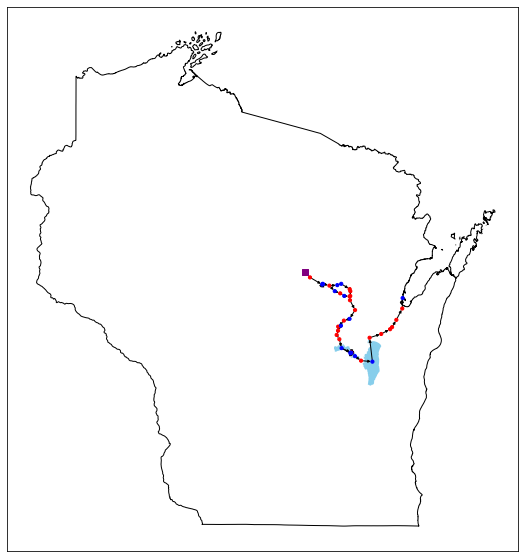

In [11]:
# Plot the downstream graph for Source2; plot the polygon of the lakes as well
# The commented section can be removed to include a legend

fig, ax = plt.subplots(figsize=(10,10))

all_nodes = [i for i in G_down2.nodes]

WI.plot(ax=ax, color="none", edgecolor="black")
WILakes[WILakes.COMID.isin(all_nodes)].plot(ax=ax, color="skyblue")
nx.draw_networkx(G_down2,pos=G_agg_pos,node_size=(np.array(node_size2)),with_labels=False,arrowsize=5,ax=ax,node_color=node_colors2)#, node_shape=node_shape_c)#,markersize=markersize)
sources[sources.Node == "source2"].plot(ax=ax, color="purple", marker="s", markersize=30, zorder=100)

#legend_elements = [
#                   Line2D([0],[0], markersize=5, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
#                   Line2D([0],[0], markersize=5, label="River Node",marker='o',color='red',linestyle="None"),
#                   Line2D([0],[0], markersize=10, label="Source Location 1", marker="s", color="orange", linestyle="None"),
#                   Line2D([0],[0], markersize=10, label="Source Location 2", marker="s", color="purple", linestyle="None"),
#                   Patch(facecolor="skyblue", edgecolor="none", label="Waterbody")]
#
#ax.legend(handles=legend_elements, loc = 'upper right',fontsize=20)